# Testing the Model

This Jupyter Notebook contains some testing done for the machine learning model that will be used for the project.

## Setting Up

First, we need to extract the features from the `binary-features.txt` file.

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

NUM_FEATURES = 16

X = np.genfromtxt("binary-features.txt", delimiter=",", usecols=np.arange(NUM_FEATURES), skip_header=1)
y = np.genfromtxt("binary-features.txt", delimiter=",", usecols=NUM_FEATURES, skip_header=1)

In [2]:
unique, counts = np.unique(y, return_counts=True)
for i in range(0, len(unique)):
    print(f"{unique[i]}: {counts[i]}")

0.0: 5
1.0: 9
3.0: 6
4.0: 6
5.0: 7
6.0: 8
7.0: 10
8.0: 6
10.0: 8
11.0: 5
12.0: 12
13.0: 7
15.0: 9
16.0: 8
17.0: 8
18.0: 5
19.0: 5
20.0: 5
21.0: 7
22.0: 7
23.0: 8
24.0: 8
26.0: 7
27.0: 7
28.0: 5
29.0: 22
30.0: 9
31.0: 6
32.0: 10
34.0: 7
35.0: 5
36.0: 5
38.0: 9
39.0: 6
41.0: 5
45.0: 5
46.0: 6
47.0: 5
48.0: 6
49.0: 6
52.0: 11
54.0: 5
55.0: 8
56.0: 13
57.0: 6
58.0: 5
59.0: 14
60.0: 7
61.0: 7
62.0: 5
63.0: 5
64.0: 7


## Getting Train and Test Sets

Now we have a set of features and a set of labels, we can get the training and testing sets using `sklearn`'s `train_test_split` function.

In [3]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2408, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Choosing a Model

To try and get the best model for the task of binary authorship attribution, we must determine the type of problem we face. Because we are trying to predict a class given a set of features, we need to use **classification** models. We can also fine-tune the models to get the best parameters.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

X_train_pr, X_valid, y_train_pr, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


pipelines_and_grids = {
    "KNN": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier())
        ]),
        {
            "clf__n_neighbors": [3, 5, 7, 9, 11],
            "clf__weights": ["uniform", "distance"],
            "clf__p": [1, 2],
        }
    ),

    "SVC": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC())
        ]),
        {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__gamma": ["scale", "auto", 0.01, 0.1, 1],
            "clf__kernel": ["rbf"],
        }
    ),

    "LogisticRegression": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000))
        ]),
        {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        }
    ),

    #"GradientBoosting": (
    #    GradientBoostingClassifier(),
    #    {
    #        "n_estimators": [100, 200, 300],
    #        "learning_rate": [0.01, 0.05, 0.1],
    #        "max_depth": [2, 3, 4],
    #    }
    #),

    "RandomForest": (
        RandomForestClassifier(class_weight="balanced"),
        {
            "n_estimators": [200, 500],
            "max_depth": [4, 6, 8, None],
            "max_features": ["sqrt", "log2"],
            "criterion": ["gini", "entropy"],
        }
    ),
}

results = {}

for name, (model, grid) in pipelines_and_grids.items():
    print(f"\nTuning {name}...")

    grid_search = GridSearchCV(
        model,
        grid,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    start = time.time()
    grid_search.fit(X_train_pr, y_train_pr)
    elapsed = time.time() - start

    best_model = grid_search.best_estimator_
    accuracy = best_model.score(X_valid, y_valid)

    print(f"Best Params: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Time: {elapsed:.2f}s")

    results[name] = {
        "best_model": best_model,
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "val_accuracy": accuracy,
        "training_time": elapsed,
    }


Tuning KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance'}
Best CV Score: 0.4109
Validation Accuracy: 0.3276
Time: 1.10s

Tuning SVC...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Params: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV Score: 0.4414
Validation Accuracy: 0.3966
Time: 0.21s

Tuning LogisticRegression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV Score: 0.4281
Validation Accuracy: 0.2931
Time: 0.45s

Tuning RandomForest...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
Best CV Score: 0.4328
Validation Accuracy: 0.3621
Time: 15.79s


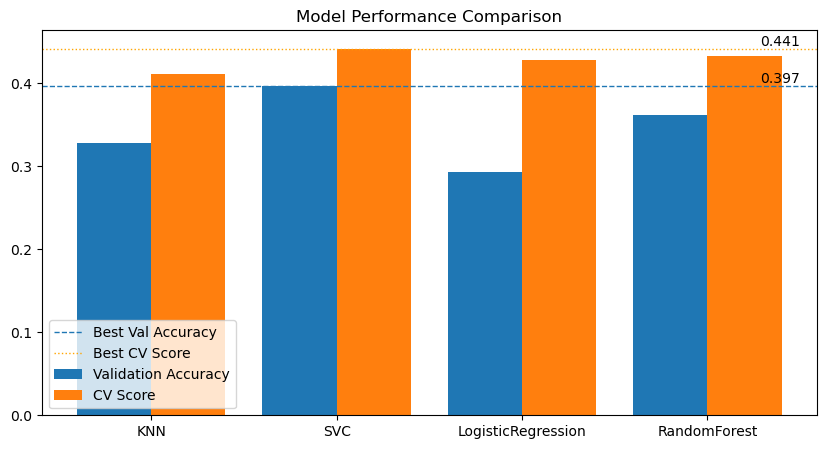

In [7]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
cv_scores = []
val_accuracies = []
speeds = []

for m in model_names:
    cv_scores.append(results[m]["cv_score"])
    val_accuracies.append(results[m]["val_accuracy"])
    speeds.append(results[m]["training_time"])

plt.figure(figsize=(10,5))
x = np.arange(len(model_names))

plt.bar(x - 0.2, val_accuracies, width=0.4, label="Validation Accuracy")
plt.bar(x + 0.2, cv_scores, width=0.4, label="CV Score")

best_val = max(val_accuracies)
best_cv = max(cv_scores)

plt.axhline(best_val, linestyle='--', linewidth=1, label='Best Val Accuracy')
plt.axhline(best_cv, linestyle=':', color='orange', linewidth=1, label='Best CV Score')

plt.text(
    x= len(model_names)-0.5,
    y= best_val,
    s=f"{best_val:.3f}",
    va='bottom',
    ha='right',
)

plt.text(
    x= len(model_names)-0.5,
    y= best_cv,
    s=f"{best_cv:.3f}",
    va='bottom',
    ha='right',
)

plt.xticks(x, model_names)
plt.title("Model Performance Comparison")
plt.legend()

plt.show()
